Import the relevant classes and libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
import time
from ipywidgets import interact
from datetime import datetime, timedelta
from matplotlib import animation
from IPython.display import HTML

## Variables

Here's where all of your config happens. Change these variables to change how the animation looks and how fast it goes.

This is a list of all of the different places where data can be accessed from. Change the number in `CURRENT_SOURCE` to point to a different location.

In [2]:
NSIDC_0046_FORMAT = "/projects/DATASETS/nsidc0046_weekly_snow_seaice/data/EASE2_N25km.snowice.{}-{}.v04.bin"
NSIDC_0046_STAGING_FORMAT = ("/disks/sidads_staging/DATASETS/nsidc0046_weekly_snow_seaice/"
                             "data/EASE2_N25km.snowice.{}-{}.v04.bin")

SOURCES = [NSIDC_0046_FORMAT, NSIDC_0046_STAGING_FORMAT]

CURRENT_SOURCE = SOURCES[0]

This is the start date and end date for the animation. The script will skip over files that don't exist. Make sure that the start date points to a file with that start date- otherwise the script will loop on the wrong days and it won't find any of the correct files.

In [3]:
TIMEFRAME = [datetime(2013, 1, 7), datetime(2014, 6, 23)]

This is the framerate for the animation. `interval` refers to the time between frames, in MS. If simpler set using the `fps` variable.

In [8]:
INTERVAL = 100
FPS = 1000/INTERVAL

Finally, use this variable to toggle log messages. (True/False, case sensitive)

In [5]:
VERBOSE = True

These are some configs and helper methods.

In [6]:
plt.rcParams['animation.writer']= 'avconv'

#blatantly copied from http://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
def daterange(timeframe):
    for n in range(int ((timeframe[1] - timeframe[0]).days / 7)):
        yield timeframe[0] + timedelta(n*7)    

def form_smashed_date(date):
    return str(date.year) + str(date.month).zfill(2) + str(date.day).zfill(2)

Rendering data for 2013-01-07 00:00:00 and 2013-01-13 00:00:00
Rendering data for 2013-01-07 00:00:00 and 2013-01-13 00:00:00
Rendering data for 2013-01-14 00:00:00 and 2013-01-20 00:00:00
Rendering data for 2013-01-21 00:00:00 and 2013-01-27 00:00:00
Rendering data for 2013-01-28 00:00:00 and 2013-02-03 00:00:00
Rendering data for 2013-02-04 00:00:00 and 2013-02-10 00:00:00
Rendering data for 2013-02-11 00:00:00 and 2013-02-17 00:00:00
Rendering data for 2013-02-18 00:00:00 and 2013-02-24 00:00:00
Rendering data for 2013-02-25 00:00:00 and 2013-03-03 00:00:00
Rendering data for 2013-03-04 00:00:00 and 2013-03-10 00:00:00
Rendering data for 2013-03-11 00:00:00 and 2013-03-17 00:00:00
Rendering data for 2013-03-18 00:00:00 and 2013-03-24 00:00:00
Rendering data for 2013-03-25 00:00:00 and 2013-03-31 00:00:00
Rendering data for 2013-04-01 00:00:00 and 2013-04-07 00:00:00
Rendering data for 2013-04-08 00:00:00 and 2013-04-14 00:00:00
Rendering data for 2013-04-15 00:00:00 and 2013-04-21 0

Rendering data for 2013-01-07 00:00:00 and 2013-01-13 00:00:00


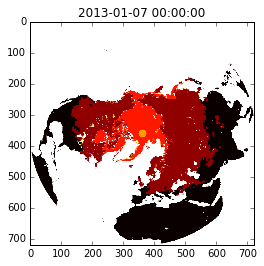

In [9]:
%matplotlib inline

index = 0
rng = []
last_dataset = None
for date in daterange(TIMEFRAME):
    rng.append(date)

def setup():
    plt.figure()

def render(index):
    start_date = get_current_datetime(index)
    end_date = start_date + timedelta(days = 6)
    uri = get_current_map().format(form_smashed_date(start_date), form_smashed_date(end_date))
    if VERBOSE:
        print("Rendering data for " + str(start_date) + " and " + str(end_date))
    try:
        with open(uri, 'rb') as fp:
           nsidc_0046_data = np.fromfile(fp, dtype=np.uint8).reshape(720, 720)
        last_dataset = nsidc_0046_data
        plt.title(str(start_date))
        sep_data = np.minimum(nsidc_0046_data, 5)
        im = plt.imshow(sep_data, cmap="hot", animated=True)
    except FileNotFoundError as e:
        print("No file called " + uri)
        plt.title("DATA MISSING FOR " + str(start_date))
        im = plt.imshow(last_dataset, animated=True)
    else:
        index += 1
        return [im]

def get_current_datetime(index):
    return rng[index]

def get_current_map():
    return CURRENT_SOURCE


fig = plt.figure()
anim = animation.FuncAnimation(fig, render, frames=len(rng), fargs=index, interval=INTERVAL, repeat=True)
HTML(anim.to_html5_video())